# Skin Cancer Classification

This notebook contains the definition and evaluation of a Convolutional Neural Network (CNN) which aims to classify skin lesion images into three categories:

- [Melanoma](https://es.wikipedia.org/wiki/Melanoma): **malign** cancer, one of the deadliest.
- [Nevus](https://en.wikipedia.org/wiki/Nevus): **benign** skin lesion (mole or birthmark).
- [Seborrheic keratosis](https://en.wikipedia.org/wiki/Seborrheic_keratosis): **benign** skin tumor.

![Skin Disease Classes](./images/skin_disease_classes.png)

The project uses the images from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.isic-archive.com/landing/2017/). Although the challenge is already closed, information on the competition can be obtained from the official [website](https://challenge.isic-archive.com/landing/2017/).

I downloaded the dataset from the following links provided by Udacity to the non-committed folder `data/`, which is subdivided in the train, validation and test subfolders as well as class-name subfolders:

- [training data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip) (5.3 GB)
- [validation data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip) (824.5 MB)
- [test data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip) (5.1 GB)

The images originate from the [ISIC Archive](https://www.isic-archive.com/).

**Table of Contents**:

- [Load Dataset](#Load-Dataset)


## 1. Load Dataset

First, let's check how balanced the ddataset is across splits and classes.

In [12]:
import numpy as np
from glob import glob

ROOT_PATH = './data/'

train_melanoma = list(glob(ROOT_PATH+"train/melanoma/*"))
train_nevus = list(glob(ROOT_PATH+"train/nevus/*"))
train_seborrheic = list(glob(ROOT_PATH+"train/seborrheic_keratosis/*"))
train_all = train_melanoma + train_nevus + train_seborrheic

print(f'Train: all: {len(train_all)}')
print(f'Train: melanoma: {len(train_melanoma)}, {100*float(len(train_melanoma))/float(len(train_all))} %')
print(f'Train: nevus: {len(train_nevus)}, {float(100*len(train_nevus))/float(len(train_all))} %')
print(f'Train: seborrheic keratosis: {len(train_seborrheic)}, {100*float(len(train_seborrheic))/float(len(train_all))} %')

test_melanoma = list(glob(ROOT_PATH+"test/melanoma/*"))
test_nevus = list(glob(ROOT_PATH+"test/nevus/*"))
test_seborrheic = list(glob(ROOT_PATH+"test/seborrheic_keratosis/*"))
test_all = test_melanoma + test_nevus + test_seborrheic

print(f'Test: all: {len(test_all)}')
print(f'Test: melanoma: {len(test_melanoma)}, {100*float(len(test_melanoma))/float(len(test_all))} %')
print(f'Test: nevus: {len(test_nevus)}, {float(100*len(test_nevus))/float(len(test_all))} %')
print(f'Test: seborrheic keratosis: {len(test_seborrheic)}, {100*float(len(test_seborrheic))/float(len(test_all))} %')

valid_melanoma = list(glob(ROOT_PATH+"valid/melanoma/*"))
valid_nevus = list(glob(ROOT_PATH+"valid/nevus/*"))
valid_seborrheic = list(glob(ROOT_PATH+"valid/seborrheic_keratosis/*"))
valid_all = valid_melanoma + valid_nevus + valid_seborrheic

print(f'Validation: all: {len(valid_all)}')
print(f'Validation: melanoma: {len(valid_melanoma)}, {100*float(len(valid_melanoma))/float(len(valid_all))} %')
print(f'Validation: nevus: {len(valid_nevus)}, {float(100*len(valid_nevus))/float(len(valid_all))} %')
print(f'Validation: seborrheic keratosis: {len(valid_seborrheic)}, {100*float(len(valid_seborrheic))/float(len(valid_all))} %')

Train: all: 2000
Train: melanoma: 374, 18.7 %
Train: nevus: 1372, 68.6 %
Train: seborrheic keratosis: 254, 12.7 %
Test: all: 600
Test: melanoma: 117, 19.5 %
Test: nevus: 393, 65.5 %
Test: seborrheic keratosis: 90, 15.0 %
Validation: all: 150
Validation: melanoma: 30, 20.0 %
Validation: nevus: 78, 52.0 %
Validation: seborrheic keratosis: 42, 28.0 %


### 1.1 Visualize some images

In [13]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

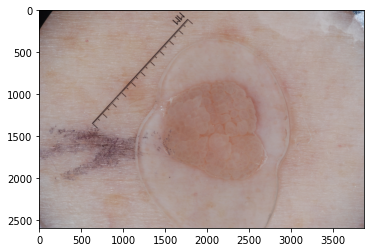

In [23]:
#file = train_melanoma[0]
#file = train_nevus[0]
file = train_seborrheic[0]
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### 1.2 Data Loaders

In [21]:
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision.transforms as transforms
from torchvision import datasets

# When transfer-learning is used we need to adapt our dataset
# to how the pre-trained networks were trained.
# In the case of VGG16/DenseNet/ResNet/Inception,
# they were trained with ImageNet, that means:
# resizing to 224x224 & scaling each channel independently:
# mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
# However, note that if we define our own network and train it, 
# we can use our own size and normalization,
# e.g.: 200x200, mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]

trainpath = ROOT_PATH+'train'
testpath = ROOT_PATH+'test'
validpath = ROOT_PATH+'valid'
batch_size = 4 # 20

# Training data with augmentation (recommended)
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(10),
                                       transforms.Resize(230),
                                       #transforms.CenterCrop(224),
                                       #transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
# Test data without augmentation
test_transforms = transforms.Compose([ 
                                       transforms.Resize(230),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Validation data without augmentation
valid_transforms = transforms.Compose([
                                       transforms.Resize(230),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(trainpath, transform=train_transforms)
test_data = datasets.ImageFolder(testpath, transform=test_transforms)
valid_data = datasets.ImageFolder(validpath, transform=valid_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loaders = {}
loaders['train'] = trainloader
loaders['test'] = testloader
loaders['valid'] = validloader

In [62]:
# We can automatically access the class names
num_classes = len(train_data.classes)
class_names = [item.replace("_", " ") for item in train_data.classes]
print(class_names)

['melanoma', 'nevus', 'seborrheic keratosis']


Note that Pytorch images are not loaded as numpy arrays, but as PIL images. Thus I define a simple function that given a PIL image visualizes it.

In [30]:
def visualize(image):
    '''Visualizes one tensor-image'''
    # Convert to numpy and (C,W,H) -> (W,H,C)
    img = image.cpu().numpy().squeeze().transpose((1, 2, 0))
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * img + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)

Target labels: [0 1 2 1] -> ['melanoma', 'nevus', 'seborrheic_keratosis', 'nevus']


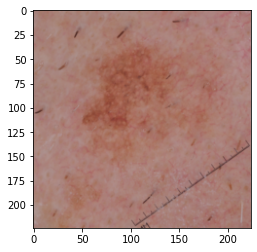

In [47]:
# Take next batch
data_iter = iter(testloader)
images, labels = next(data_iter)

# Print labels
print(f'Target labels: {labels.data.numpy()} -> {[class_names[i] for i in labels.data.numpy()]}')

# Visualize one image from the batch
image = images[0]
visualize(image)

## 2. Model Definition

In [53]:
import torchvision.models as models
import torch.nn as nn

model = models.inception_v3(pretrained=True)
#model = models.resnet50(pretrained=True)
#model = models.densenet121(pretrained=True)
#model = models.vgg16(pretrained=True)

print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [54]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()

In [58]:
# Freeze parameters of the pre-trained network
# so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define our own last classifier layers
# Our inputs must match with the ones
# in the pre-trained network (in_features)
# and REPLACE the model.fc
from collections import OrderedDict
drop_p=0.5
num_classes=3
hidden_nodes = 256 # 500
model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, hidden_nodes)),
                          ('relu1', nn.ReLU()),
                          ('drop1', nn.Dropout(drop_p)),
                          ('fc2', nn.Linear(hidden_nodes, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# This should not be necessary
for param in model.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model = model.cuda()
    
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [59]:
# Custom save & load functions
def save_model(filepath, model):
    torch.save(model.state_dict(), filepath)

def load_checkpoint(filepath, model):
    dev = 'cpu'
    #checkpoint = torch.load(filepath, map_location=torch.device(dev))
    checkpoint = torch.load(filepath, map_location=dev)
    model.load_state_dict(checkpoint)
    return model

In [60]:
filepath = './models/model_0.pt'
save_model(filepath, model)
model = load_checkpoint(filepath, model)

In [65]:
def predict(img_path, model, use_cuda, class_names):
    '''
    Use model to infer skin lesion class given an image
    
    Args:
        img_path: path to an image
        
    Returns:
        Class name
    '''

    # Note: transforms takes PIL formatted images, not numpy arrays
    img = Image.open(img_path) 
    
    # ImageNet dataset requires a specific mean & std normalization
    data_transforms = transforms.Compose([
        transforms.Resize(230),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # Apply data data transformations and add a dimension for batches
    img_batch = data_transforms(img).unsqueeze(0)

    if use_cuda:
        model = model.cuda()
        img_batch = img_batch.to("cuda", dtype=torch.float)
    
    # Set in evaluation mode! (De-activate dropout, etc.)
    model.eval()
    
    # Predict. Apply softmax to convert logits
    with torch.no_grad():
        # Prediction
        logps = model(img_batch).squeeze(0)
        prediction = torch.exp(logps)
        prediction = prediction.cpu()

        # Feature Vector
        
        
    # Class id: index of maximum probability
    class_id = prediction.argmax().item()
    
    return class_names[class_id] # predicted class name

In [70]:
img_path = train_all[0]
print(img_path)
predict(img_path, model, use_cuda, class_names)

./data/train/melanoma/ISIC_0000031.jpg


'seborrheic keratosis'

In [78]:
list(model.children())[0]

BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)